# Labor Parktikum 2

In [41]:
# Vorbereitung zur Datenverarbeitung

import pandas as pd
import numpy as np
import scipy.signal as sc 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
from scipy.signal import butter, filtfilt, find_peaks
import neurokit2 as nk
import os
from Lab2Functions import decg_peaks, d_ecg_peaks, Rwave_peaks

#Daten Einlesen:
dataBTOM = pd.read_csv('data/BelastungEKGTOM.csv', sep='\t')
dataRTOM = pd.read_csv('data/RuheEKGTOM.csv', sep='\t')
dataRGEORG = pd.read_csv('data/RuheEKGGEORG.csv', sep='\t')
dataRALEX = pd.read_csv('data/RuheEKGALEX.csv', sep='\t')
dataRAMELIE = pd.read_csv('data/RuheEKGAMELIE.csv', sep='\t')

#Spalten benennen:
dataBTOM.columns = ['EKG', 'Time']
dataRTOM.columns = ['EKG', 'Time']
dataRGEORG.columns = ['EKG', 'Time']
dataRAMELIE.columns = ['EKG', 'Time']
dataRALEX.columns = ['EKG', 'Time']

# Filtern der Daten
Wn = 0.1 
b, a = sc.butter(4, Wn, 'low', analog=False)

#Ruhe EKG TOM:
fdataRTOM = filtfilt(b, a, dataRTOM['EKG'])

#Ruhe EKG GEORG:
fdataRGEORG = filtfilt(b, a, dataRGEORG['EKG'])

#Ruhe EKG AMELIE:
fdataRAMELIE = filtfilt(b, a, dataRAMELIE['EKG'])

#Ruhe EKG ALEX:
fdataRALEX = filtfilt(b, a, dataRALEX['EKG'])

## Aufgabe 3

Führen Sie Aufgabe 1 Teil 4: Experiment in Ruhe für jeden Teilnehmer Ihrer Gruppe aus und plotten Sie 5 Sekunden der gefilterten Daten. Markieren Sie für einen Teilnehmer die P-Welle, den QRS-Komplex und die T-Welle im Plot. Beschreiben Sie das physiologische Phänomen, welches für die jeweiligen elektrischen Signale des EKGs verantwortlich ist.

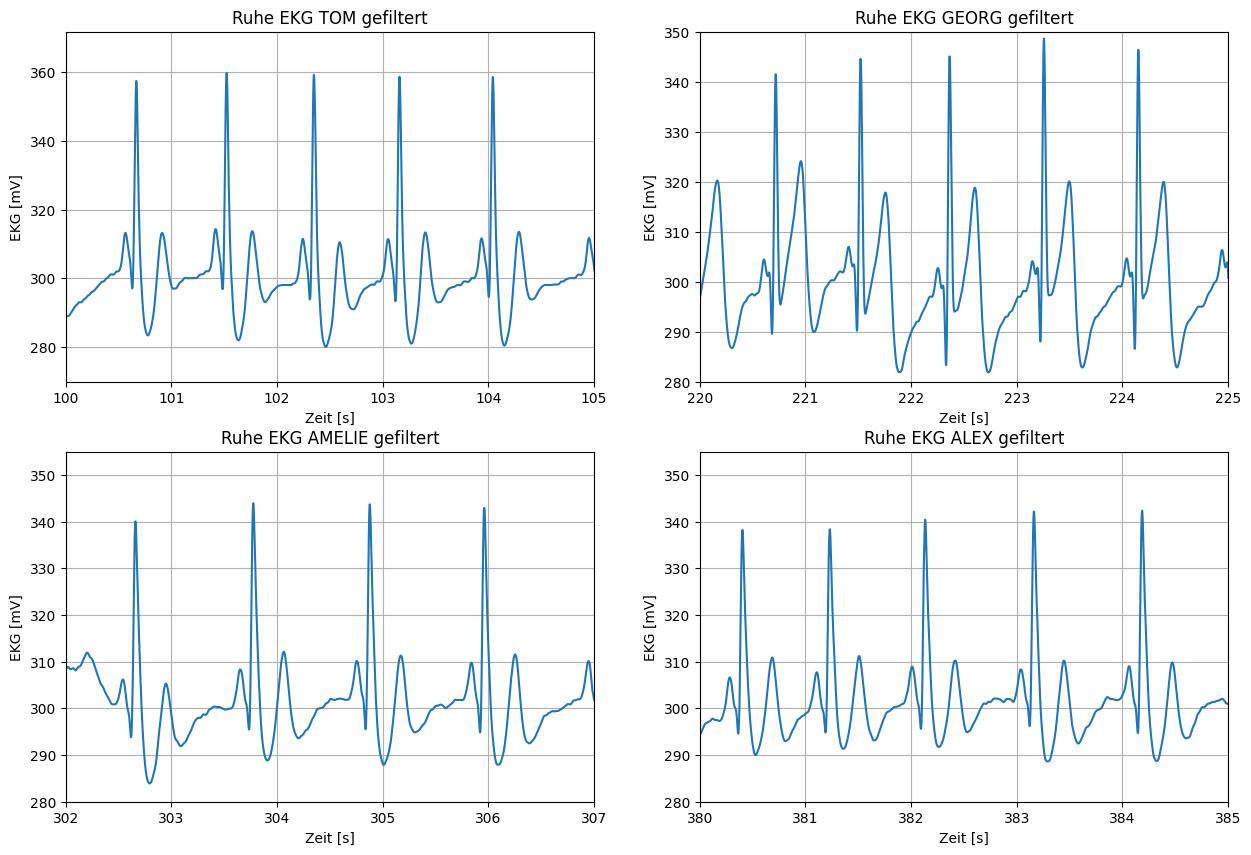

In [56]:
# Plot der gefilterten Daten für 5 Sekunden im Format 2x2

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Ruhe EKG TOM
axs[0, 0].plot(dataRTOM['Time']/1000, fdataRTOM)
axs[0, 0].set_xlim(100, 105)
axs[0, 0].set_title('Ruhe EKG TOM gefiltert')
axs[0, 0].set_xlabel('Zeit [s]')
axs[0, 0].set_ylabel('EKG [mV]')
axs[0, 0].grid()

# Ruhe EKG GEORG
axs[0, 1].plot(dataRGEORG['Time']/1000, fdataRGEORG)
axs[0, 1].set_xlim(220, 225)
axs[0, 1].set_ylim(280, 350)
axs[0, 1].set_title('Ruhe EKG GEORG gefiltert')
axs[0, 1].set_xlabel('Zeit [s]')
axs[0, 1].set_ylabel('EKG [mV]')
axs[0, 1].grid()

# Ruhe EKG AMELIE
axs[1, 0].plot(dataRAMELIE['Time']/1000, fdataRAMELIE)
axs[1, 0].set_xlim(302, 307)
axs[1, 0].set_ylim(280, 355)
axs[1, 0].set_title('Ruhe EKG AMELIE gefiltert')
axs[1, 0].set_xlabel('Zeit [s]')
axs[1, 0].set_ylabel('EKG [mV]')
axs[1, 0].grid()

# Ruhe EKG ALEX
axs[1, 1].plot(dataRALEX['Time']/1000, fdataRALEX)
axs[1, 1].set_xlim(380, 385)
axs[1, 1].set_ylim(280, 355)
axs[1, 1].set_title('Ruhe EKG ALEX gefiltert')
axs[1, 1].set_xlabel('Zeit [s]')
axs[1, 1].set_ylabel('EKG [mV]')
axs[1, 1].grid()

plt.show()

## Aufgabe 3 & 5

Plotten Sie etwa 5 Sekunden des EKG-Signals vom Experiment in Ruhe von einem der Teilnehmer (gefiltert). Nutzen Sie die Ergebnisse der PeakSuche-Funktion, um die R-Zacken im Plot zu labeln.

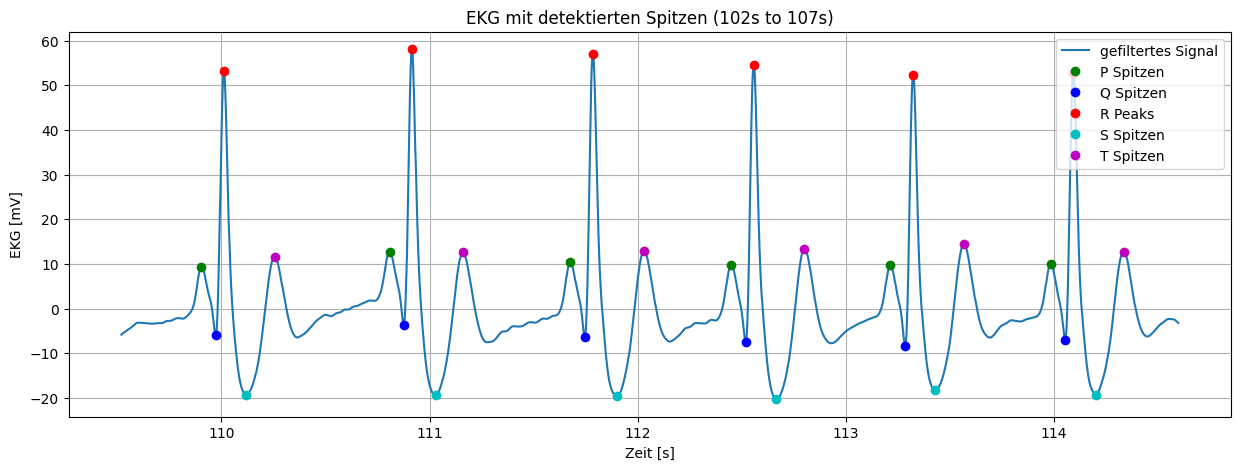

In [57]:
import numpy as np
import scipy.signal as sc
import matplotlib.pyplot as plt
import neurokit2 as nk


def bandpass_filter(sig, lowcut, highcut, fs):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = sc.butter(1, [low, high], btype='band')
    return sc.filtfilt(b, a, sig)

fs = 500  # Sampling rate
filtered_signal = bandpass_filter(fdataRTOM, 0.5, 50, fs)

# Detect R-peaks
_, r_peaks = nk.ecg_peaks(fdataRTOM, sampling_rate=fs)

# Define start and end time for plotting
start_time = 102
end_time = start_time + 5
start_idx = int(start_time * fs)
end_idx = int(end_time * fs)

signal_window = filtered_signal[start_idx:end_idx]
time_window = dataRTOM['Time'][start_idx:end_idx] / 1000

# We'll store final detected peaks
p_peaks = []
q_peaks = []
s_peaks = []
t_peaks = []

# Convert times to samples for relative searches
def ms_to_samples(ms):
    return int((ms/1000) * fs)

for i in range(1, len(r_peaks['ECG_R_Peaks']) - 1):
    r_loc = r_peaks['ECG_R_Peaks'][i]
    # To find Q and S, we assume Q and R are correct as per your statement
    # Let's re-detect Q around R more systematically:
    
    # Search window for Q (50ms before R): Q is just before R as a negative deflection
    q_search_window_start = max(r_loc - ms_to_samples(50), 0)
    q_search_window_end = r_loc
    q_segment = filtered_signal[q_search_window_start:q_search_window_end]
    if len(q_segment) > 0:
        # Q is a local minimum before R
        q_rel_idx, _ = sc.find_peaks(-q_segment)
        if len(q_rel_idx) > 0:
            # Take the largest negative peak (lowest point)
            q_min_idx = q_rel_idx[np.argmin(q_segment[q_rel_idx])] 
            q_loc = q_search_window_start + q_min_idx
        else:
            q_loc = None
    else:
        q_loc = None
    
    # If Q is found, mark it
    q_peaks.append(q_loc)
    
    # P peak: occur before Q.
    # Let's search in a window from Q-120ms to Q-20ms before Q
    # (Adjust these as needed)
    if q_loc is not None:
        p_search_start = max(q_loc - ms_to_samples(120), 0)
        p_search_end = q_loc - ms_to_samples(20)
        if p_search_end > p_search_start:
            p_segment = filtered_signal[p_search_start:p_search_end]
            if len(p_segment) > 0:
                # P is often a small positive wave before Q
                # Find a local maximum in that segment
                p_rel_idx, _ = sc.find_peaks(p_segment)
                if len(p_rel_idx) > 0:
                    # Choose the highest peak as P
                    p_max_idx = p_rel_idx[np.argmax(p_segment[p_rel_idx])]
                    p_loc = p_search_start + p_max_idx
                else:
                    p_loc = None
            else:
                p_loc = None
        else:
            p_loc = None
    else:
        p_loc = None
    
    p_peaks.append(p_loc)
    
    # S peak: after R
    # Typically S occurs shortly after R (within 40ms)
    s_search_start = r_loc
    s_search_end = min(r_loc + ms_to_samples(500), len(filtered_signal))
    s_segment = filtered_signal[s_search_start:s_search_end]
    if len(s_segment) > 0:
        # S is a negative deflection after R
        # By using `find_peaks(-s_segment)`, we look for minima in the original signal.
        s_rel_idx, _ = sc.find_peaks(-s_segment)
        if len(s_rel_idx) > 0:
            # Pick the index of the lowest point
            s_min_idx = s_rel_idx[np.argmin(s_segment[s_rel_idx])]
            s_loc = s_search_start + s_min_idx
        else:
            s_loc = None
    else:
        s_loc = None
    
    s_peaks.append(s_loc)
    
    # T peak: occurs later, let's say 200ms after R to 400ms after R
    # Adjust as needed based on your data.
    t_search_start = r_loc + ms_to_samples(200)
    t_search_end = min(r_loc + ms_to_samples(400), len(filtered_signal))
    if s_loc is not None and s_loc > r_loc:
        # We can also start after S if you prefer, but let's use 200ms after R as a baseline
        # If you want after S, you could do max(s_loc+ms_to_samples(50), t_search_start)
        t_search_start = max(t_search_start, s_loc + ms_to_samples(50))
    t_segment = filtered_signal[t_search_start:t_search_end]
    if len(t_segment) > 0:
        # T is a positive peak usually
        t_rel_idx, _ = sc.find_peaks(t_segment)
        if len(t_rel_idx) > 0:
            # Choose the highest peak for T
            t_max_idx = t_rel_idx[np.argmax(t_segment[t_rel_idx])]
            t_loc = t_search_start + t_max_idx
        else:
            t_loc = None
    else:
        t_loc = None

    t_peaks.append(t_loc)

# Plotting
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(time_window, signal_window, label='gefiltertes Signal')
ax.set_title(f'EKG mit detektierten Spitzen ({start_time}s to {end_time}s)')
ax.set_xlabel('Zeit [s]')
ax.set_ylabel('EKG [mV]')
ax.grid()

# R peaks in window
r_peaks_window = [r for r in r_peaks['ECG_R_Peaks'] if start_idx <= r < end_idx]
ax.plot(dataRTOM['Time'][r_peaks_window]/1000, filtered_signal[r_peaks_window], 'ro', label='R Peaks')

p_peaks_window = [p for p in p_peaks if p is not None and start_idx <= p < end_idx]
q_peaks_window = [q for q in q_peaks if q is not None and start_idx <= q < end_idx]
s_peaks_window = [s for s in s_peaks if s is not None and start_idx <= s < end_idx]
t_peaks_window = [t for t in t_peaks if t is not None and start_idx <= t < end_idx]

ax.plot(dataRTOM['Time'][p_peaks_window]/1000, filtered_signal[p_peaks_window], 'go', label='P Spitzen')
ax.plot(dataRTOM['Time'][q_peaks_window]/1000, filtered_signal[q_peaks_window], 'bo', label='Q Spitzen')
ax.plot(dataRTOM['Time'][s_peaks_window]/1000, filtered_signal[s_peaks_window], 'co', label='S Spitzen')
ax.plot(dataRTOM['Time'][t_peaks_window]/1000, filtered_signal[t_peaks_window], 'mo', label='T Spitzen')

# Change the order of the legend
handles, labels = ax.get_legend_handles_labels()
order = [0, 2, 3, 1, 4, 5]  # Adjust the order as needed
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order])

plt.show()

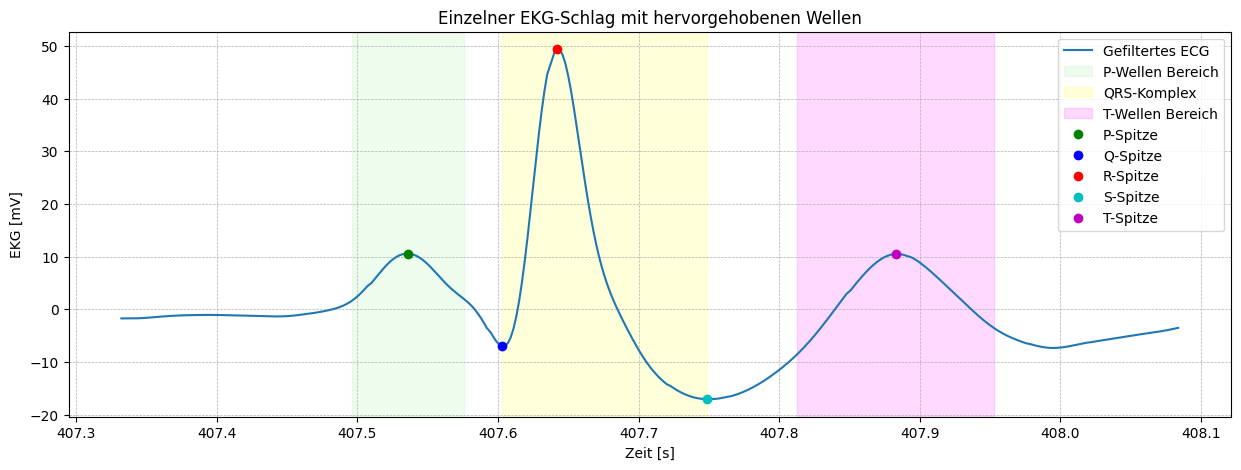

In [58]:
beat_idx = 500  # Zum Beispiel, zeige den ersten erkannten Schlag

# Extrahiere die Spitzen-Indizes für diesen Schlag
# Hinweis: Stelle sicher, dass deine p_peaks, q_peaks, s_peaks, t_peaks Indizes mit den R-Spitzen übereinstimmen
p_loc = p_peaks[beat_idx]
q_loc = q_peaks[beat_idx]
s_loc = s_peaks[beat_idx]
t_loc = t_peaks[beat_idx]

# Für R, je nach Indizierung, musst du vorsichtig sein:
# Wenn deine R-Spitzen-Liste direkt übereinstimmt (z.B. gleiche Indizierung), mache folgendes:
r_loc = r_peaks['ECG_R_Peaks'][beat_idx+1]  # +1, wenn die p,q,s,t Indizierung mit der zweiten R-Spitze beginnt

# Definiere eine Hilfsfunktion, um ms in Samples umzuwandeln
def ms_to_samples(ms, fs=500):
    return int((ms/1000) * fs)

# Bestimme ein Plot-Fenster um den Schlag
# Zum Beispiel: 200 ms vor der P-Welle bis 200 ms nach der T-Welle
start_view = max(p_loc - ms_to_samples(200), 0)
end_view = min(t_loc + ms_to_samples(200), len(filtered_signal))

time_segment = dataRTOM['Time'][start_view:end_view]/1000
ecg_segment = filtered_signal[start_view:end_view]

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(time_segment, ecg_segment, label='Gefiltertes ECG')

# Hebe nun die interessierenden Bereiche hervor.
# Für die P-Welle haben wir nur einen Peak-Punkt. Markiere einen kleinen Bereich um ihn, z.B. ±40ms
ax.axvspan((dataRTOM['Time'][p_loc]/1000 - 0.04), (dataRTOM['Time'][p_loc]/1000 + 0.04),
           color='lightgreen', alpha=0.15, label='P-Wellen Bereich')

# Markiere den Q bis S Bereich (QRS-Komplex)
ax.axvspan(dataRTOM['Time'][q_loc]/1000, dataRTOM['Time'][s_loc]/1000,
           color='yellow', alpha=0.15, label='QRS-Komplex')

# Für die T-Welle, markiere auch einen kleinen Bereich um sie, z.B. ±70ms
ax.axvspan((dataRTOM['Time'][t_loc]/1000 - 0.07), (dataRTOM['Time'][t_loc]/1000 + 0.07),
           color='magenta', alpha=0.15, label='T-Wellen Bereich')

# Markiere die einzelnen Spitzen
ax.plot(dataRTOM['Time'][p_loc]/1000, filtered_signal[p_loc], 'go', label='P-Spitze')
ax.plot(dataRTOM['Time'][q_loc]/1000, filtered_signal[q_loc], 'bo', label='Q-Spitze')
ax.plot(dataRTOM['Time'][r_loc]/1000, filtered_signal[r_loc], 'ro', label='R-Spitze')
ax.plot(dataRTOM['Time'][s_loc]/1000, filtered_signal[s_loc], 'co', label='S-Spitze')
ax.plot(dataRTOM['Time'][t_loc]/1000, filtered_signal[t_loc], 'mo', label='T-Spitze')

ax.set_title('Einzelner EKG-Schlag mit hervorgehobenen Wellen')
ax.set_xlabel('Zeit [s]')
ax.set_ylabel('EKG [mV]')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend()
plt.show()


## Aufgabe 5  
erledigt mit dem Code aus Lab2Functions.py

      EKG   Time
2550  301  11081
2551  301  11083
2552  300  11085
2553  300  11087
2554  299  11089
...   ...    ...
5045  299  16150
5046  299  16152
5047  299  16154
5048  300  16156
5049  300  16158

[2500 rows x 2 columns]


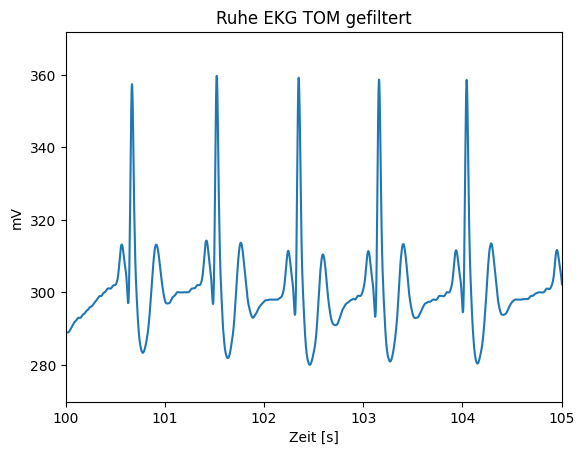

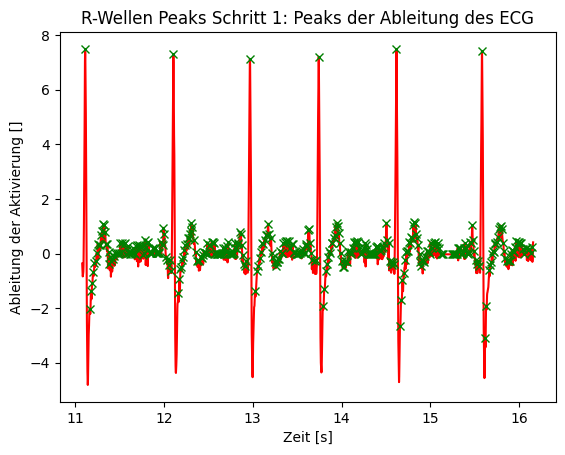

In [59]:
#Schritt 1:
plt.figure(1)
plt.plot(dataRTOM['Time']/1000, fdataRTOM)
plt.xlim(100, 105)
plt.xlabel('Zeit [s]')
plt.ylabel('mV')
plt.title('Ruhe EKG TOM gefiltert')

start_index = 2550
end_index = 5049

df_5sek_TOM = dataRTOM.iloc[start_index:end_index+1]
print(df_5sek_TOM)

f5sekdataRTOM = filtfilt(b, a, df_5sek_TOM['EKG'])
d_ecg, peaks_d_ecg = decg_peaks(f5sekdataRTOM, (df_5sek_TOM['Time'].reset_index(drop=True))/1000)



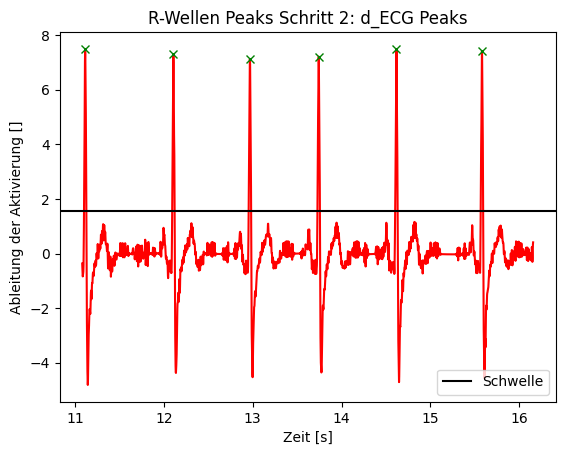

In [60]:
#Schritt 2:
Rwave_peaks_d_ecg = d_ecg_peaks(d_ecg, peaks_d_ecg, df_5sek_TOM['Time'].reset_index(drop=True)/1000, 0.4, 0.5)

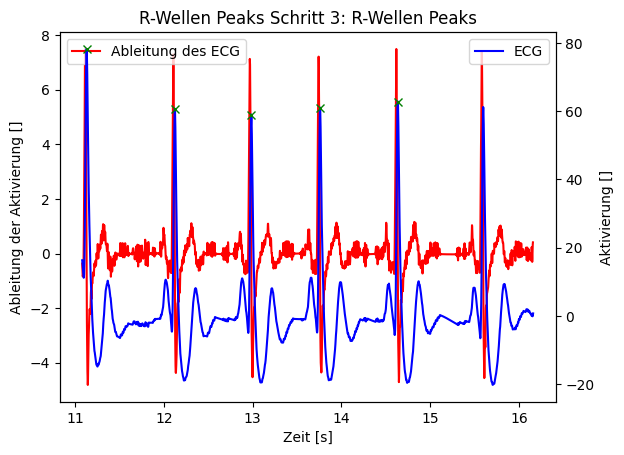

In [61]:
#Schritt 3:
Rwave_t = Rwave_peaks(f5sekdataRTOM, d_ecg, Rwave_peaks_d_ecg, df_5sek_TOM['Time'].reset_index(drop=True)/1000)

## Aufgabe 6

HRV Berechnugn und Auswertung

In [62]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def calculate_heart_rate_and_hrv(time_df, ekg_signal, time_column, sampling_rate, threshold=0.5):
    if not isinstance(time_df, pd.DataFrame):
        raise ValueError("time_df must be a Pandas DataFrame.")
    
    time = time_df[time_column]
    if time.max() > 1000:
        time = time / 1000.0
    
    if isinstance(ekg_signal, np.ndarray):
        ekg_signal = pd.Series(ekg_signal)
    
    distance = sampling_rate * 0.8  
    peaks, properties = find_peaks(ekg_signal, distance=distance, height=threshold)
    
    peak_times = time.iloc[peaks]
    rr_intervals = np.diff(peak_times)
    
    bpm = 60 / rr_intervals.mean() if len(rr_intervals) > 0 else 0
    hrv = np.std(rr_intervals) * 1000 if len(rr_intervals) > 0 else 0
    
    return bpm, hrv

def analyze_multiple_dataframes_with_hrv(time_dfs, ekg_signals, sampling_rate, time_column='Time'):
    results = []
    for (time_df, name), ekg_signal in zip(time_dfs, ekg_signals):
        bpm, hrv = calculate_heart_rate_and_hrv(time_df, ekg_signal, time_column, sampling_rate)
        results.append((name, bpm, hrv))
    return results

lowcut = 0.5
highcut = 50.0
sampling_rate = 250
b, a = butter_bandpass(lowcut, highcut, sampling_rate)

time_dfs = [
    (dataRTOM, "Tom"),
    (dataRAMELIE, "Amelie"),
    (dataRGEORG, "Georg"),
    (dataRALEX, "Alex")
]

ekg_signals = [
    filtfilt(b, a, dataRTOM['EKG']),
    filtfilt(b, a, dataRAMELIE['EKG']),
    filtfilt(b, a, dataRGEORG['EKG']),
    filtfilt(b, a, dataRALEX['EKG'])
]

results = analyze_multiple_dataframes_with_hrv(time_dfs, ekg_signals, sampling_rate)



for name, bpm, hrv in results:
    print(f"Herzfrequenz von {name}: {bpm:.2f} bpm, HRV: {hrv:.4f} ms")

Herzfrequenz von Tom: 76.89 bpm, HRV: 103.0878 ms
Herzfrequenz von Amelie: 90.15 bpm, HRV: 202.5028 ms
Herzfrequenz von Georg: 72.24 bpm, HRV: 64.1668 ms
Herzfrequenz von Alex: 83.26 bpm, HRV: 192.5157 ms


## Aufgabe 8, 9, 10

Verarbeiten der Leistungs EKG Daten

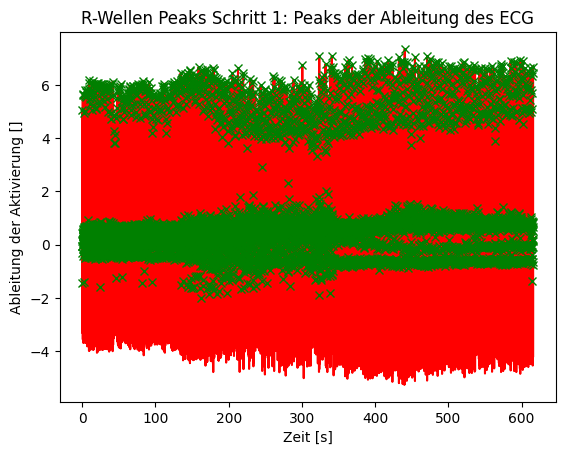

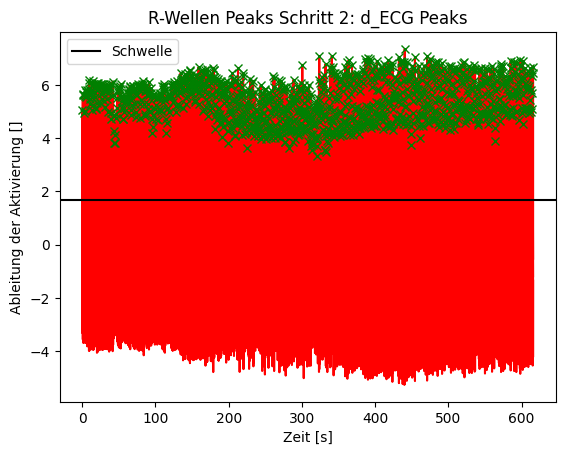

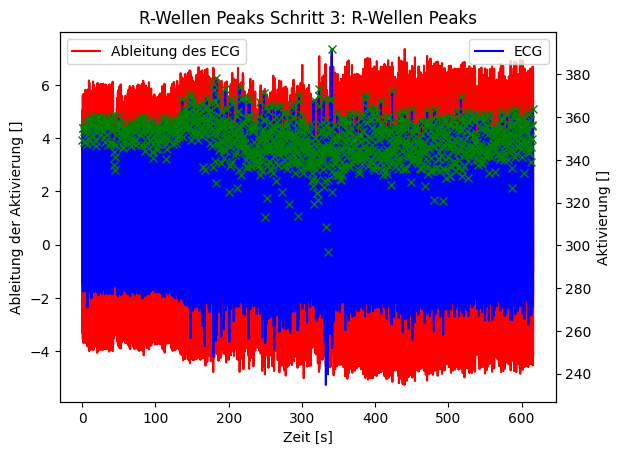

In [63]:
b2, a2 = sc.butter(4, Wn, btype="lowpass")
excercise_hr_filt = sc.filtfilt(b2, a2, dataBTOM["EKG"])

d_ecg, peaks_d_ecg = decg_peaks(excercise_hr_filt, dataBTOM['Time']/1000)
Rwave_peaks_d_ecg = d_ecg_peaks(d_ecg, peaks_d_ecg, dataBTOM['Time']/1000, 0.4, 0.5)
Rwave_t = Rwave_peaks(excercise_hr_filt, d_ecg, Rwave_peaks_d_ecg,  dataBTOM['Time']/1000)



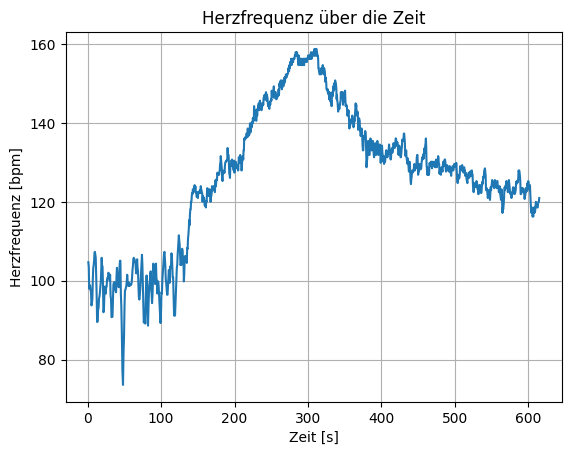

In [64]:
# HR berechnung über die R peak Zeitpunkte
rr_intervals = np.diff(Rwave_t)
bpm = 60 / rr_intervals
plt.figure(1)
plt.plot(Rwave_t[1:], bpm)
plt.xlabel('Zeit [s]')
plt.ylabel('Herzfrequenz [bpm]')
plt.title('Herzfrequenz über die Zeit')
plt.grid()
plt.show()

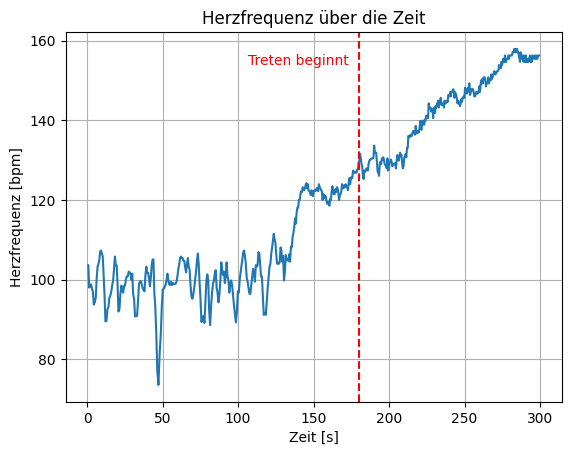

In [65]:
# Plotten der HR über die ersten 3 Minuten

plt.figure(2)
plt.plot(Rwave_t[1:600], bpm[1:600])
plt.xlabel('Zeit [s]')
plt.ylabel('Herzfrequenz [bpm]')
plt.title('Herzfrequenz über die Zeit')
plt.grid()
plt.axvline(x=180, color='r', linestyle='--')
plt.text(140, plt.ylim()[1]*0.95, 'Treten beginnt', color='r', ha='center')
plt.show()

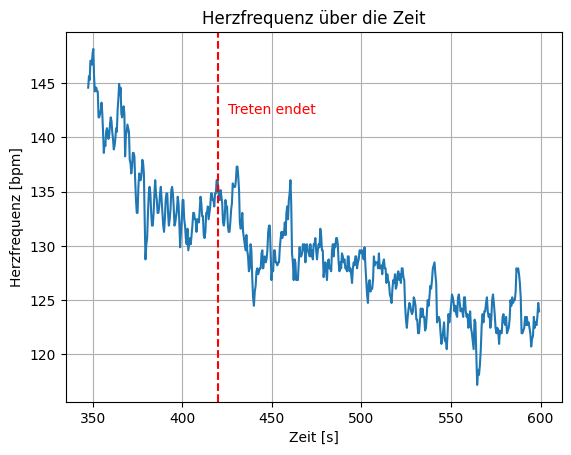

In [66]:
# Plotten der HR über 4 Minuten mit dem zeitpunkt des Starts der Ruhphase
plt.figure(2)
plt.plot(Rwave_t[720:1265], bpm[720:1265])
plt.xlabel('Zeit [s]')
plt.ylabel('Herzfrequenz [bpm]')
plt.title('Herzfrequenz über die Zeit')
plt.grid()
plt.axvline(x=420, color='r', linestyle='--')
plt.text(450, plt.ylim()[1]*0.95, 'Treten endet', color='r', ha='center')
plt.show()

## Aufgabe 12

Berrechnung des metabolischen Enegrieverbrauchs


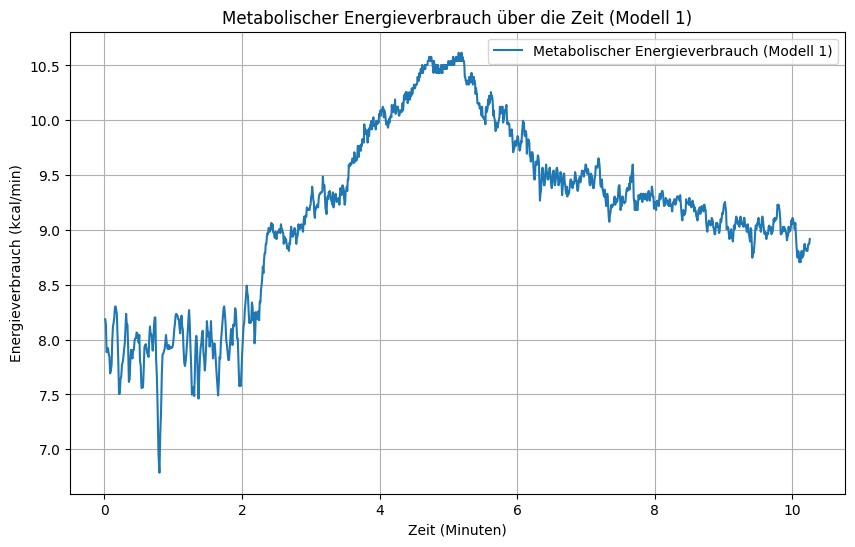

np.float64(8.937113732272689)

In [24]:
# Koeffizienten für das einfachere Modell (Modell 1) aus der Tabelle
Konstante_modell1 = -4.70  # Konstante
a_HR = 0.045  # Koeffizient für Herzfrequenz (HR)
b_weight = 0.0019  # Koeffizient für Gewicht
c_sex = 9.26  # Koeffizient für Geschlecht (0 = weiblich, 1 = männlich)
d_activity = -1.22  # Koeffizient für Aktivitätsniveau (0 = niedrig, 1 = hoch)

# Beispielwerte für die Berechnung
HR = bpm  # Herzfrequenz steigt von 80 bis 140 bpm über 60 Minuten
Gewicht = 70  # Gewicht in kg
Geschlecht = 1  # 0 = weiblich, 1 = männlich
Aktivitätsniveau = 1  # 0 = niedrig, 1 = hoch

# Berechnung des Energieverbrauchs pro Minute über die Zeit mit Modell 1
EE_values_modell1 = (
    Konstante_modell1
    + a_HR * HR
    + b_weight * Gewicht
    + c_sex * Geschlecht
    + d_activity * Aktivitätsniveau
)

# Plot des metabolischen Energieverbrauchs über die Zeit mit Modell 1
plt.figure(figsize=(10, 6))
plt.plot(Rwave_t[1:]/60, EE_values_modell1, label="Metabolischer Energieverbrauch (Modell 1)")
plt.xlabel("Zeit (Minuten)")
plt.ylabel("Energieverbrauch (kcal/min)")
plt.title("Metabolischer Energieverbrauch über die Zeit (Modell 1)")
plt.legend()
plt.grid()
plt.show()

# Relative Änderung des Energieverbrauchs (prozentual) für Modell 1
relative_änderung_modell1 = ((EE_values_modell1[-1] - EE_values_modell1[0]) / EE_values_modell1[0]) * 100
relative_änderung_modell1

## Aufgabe 13

Berechnung des Energieverbrauchs mit einem komplexeren Modell (Modell 3) und Anwendung auf Beispiele

Gesamter Energieverbrauch während des Experiments: 70.99 kcal
In Joule: 297019.11 J
In Ritter-Sport-Tafeln: 0.13 Tafeln
In Bier: 0.35 Flaschen
Prozentualer Anteil am täglichen Kalorienbedarf: 4.19%


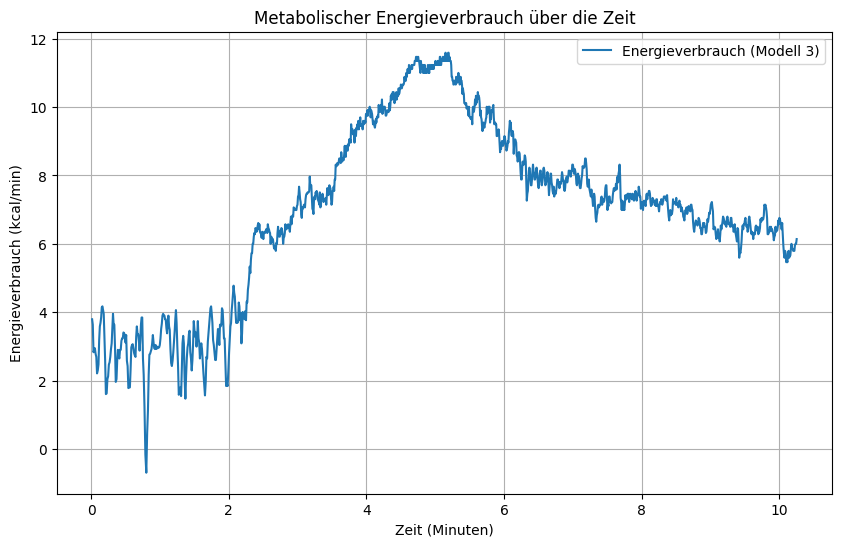

In [25]:
# Definition der konstanten Parameter für Modell 3
Konstante_modell3 = 0.84
a_HRnet = 0.011
b_weight = 0.0054
c_sex = -0.40
d_activity = -0.73
HR_weight_interaction = 0.00106
HR_sex_interaction = 0.010
HR_activity_interaction = 0.049

# Beispielwerte für die Berechnung
Geschlecht = 1  # 0 = weiblich, 1 = männlich
Aktivitätsniveau = 1  # 0 = niedrig, 1 = hoch
Gewicht = 70  # Gewicht in kg
Ruheherzfrequenz = 79  # Ruheherzfrequenz in bpm

# Simulierte Herzfrequenzwerte (z. B. während eines 30-minütigen Experiments)
zeit = Rwave_t[1:] / 60  # Zeit in Minuten, 300 Messpunkte
Aktuelle_Herzfrequenz = bpm  # Beispielhafte Variation der Herzfrequenz

# Berechnung von HRnet
HRnet_values = Aktuelle_Herzfrequenz - Ruheherzfrequenz

# Berechnung des Energieverbrauchs pro Minute mit Modell 3
EE_values_modell3 = (
    Konstante_modell3
    + a_HRnet * HRnet_values
    + b_weight * Gewicht
    + c_sex * Geschlecht
    + d_activity * Aktivitätsniveau
    + HR_weight_interaction * HRnet_values * Gewicht
    + HR_sex_interaction * HRnet_values * Geschlecht
    + HR_activity_interaction * HRnet_values * Aktivitätsniveau
)

# Gesamter Energieverbrauch (kcal) während des Experiments
Gesamtkalorien = np.trapezoid(EE_values_modell3, zeit)

# Umrechnung in verschiedene Einheiten
Gesamtjoule = Gesamtkalorien * 4184  # 1 kcal = 4184 J
Kalorien_pro_rittersport = 550  # Beispiel: 550 kcal pro Tafel
Ritter_sport_tafeln = Gesamtkalorien / Kalorien_pro_rittersport

Kalorien_pro_bier = 200  # Beispiel: 200 kcal pro 500 ml Bier
Bier_flachen = Gesamtkalorien / Kalorien_pro_bier

# Beispielberechnung des täglichen Kalorienbedarfs
Alter = 21  # Alter in Jahren
Groesse = 1.75  # Größe in Metern
Geschlecht_faktor = 5 if Geschlecht == 1 else -161  # Faktor für Geschlecht
Kalorienbedarf = 10 * Gewicht + 6.25 * (Groesse * 100) - 5 * Alter + Geschlecht_faktor
Prozent_kalorienbedarf = (Gesamtkalorien / Kalorienbedarf) * 100

# Ausgabe der Ergebnisse
print(f"Gesamter Energieverbrauch während des Experiments: {Gesamtkalorien:.2f} kcal")
print(f"In Joule: {Gesamtjoule:.2f} J")
print(f"In Ritter-Sport-Tafeln: {Ritter_sport_tafeln:.2f} Tafeln")
print(f"In Bier: {Bier_flachen:.2f} Flaschen")
print(f"Prozentualer Anteil am täglichen Kalorienbedarf: {Prozent_kalorienbedarf:.2f}%")

# Plot des Energieverbrauchs über die Zeit
plt.figure(figsize=(10, 6))
plt.plot(zeit, EE_values_modell3, label="Energieverbrauch (Modell 3)")
plt.xlabel("Zeit (Minuten)")
plt.ylabel("Energieverbrauch (kcal/min)")
plt.title("Metabolischer Energieverbrauch über die Zeit")
plt.legend()
plt.grid()
plt.show()